<a href="https://colab.research.google.com/github/shchoe/datascience/blob/master/Mario_Data_Processing_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Dec  5 15:26:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns 
import matplotlib.pyplot as plt
!pip install -q wordcloud
import wordcloud
from gensim.parsing.preprocessing import preprocess_string

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

import io
import unicodedata
import re
import string

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


As Machine Learning performs better with more training dataset, looked for most reviewed product. The first five brands from asin (Amazon Product ID) value count were: Toppik, Mario Badescu, Hot Tools, Mario Badescu, Toppik. Toppik = 6954 + 3460 = 10,414 and Mario Badescu = 6138 + 4300 = 10,438. Therefore, we will analyze Mario Badescu products.

Fetch data from Google Drive

In [3]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


link = 'https://drive.google.com/file/d/11c7JaLrA2QEICLOui86_To4er7Ah_xzs'


fluff, id = link.split('d/')
print (id)


#Store in pandas dataframe
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('beauty_full.csv')  
df = pd.read_csv('beauty_full.csv', index_col='Unnamed: 0')

11c7JaLrA2QEICLOui86_To4er7Ah_xzs


In [4]:
df.head()

,overall,asin,reviewText,title,posneg_bi,mario
1,5,B0007MYMW8,Love this scrub. I have oilier skin and it is ...,"Mario Badescu Kiwi Face Scrub, 4 oz.",1,1
2,5,B0007MYMW8,This face scrub is amazing for dry and patchy ...,"Mario Badescu Kiwi Face Scrub, 4 oz.",1,1
3,1,B0007MYMW8,This product doesn't exfoliate. The cream is t...,"Mario Badescu Kiwi Face Scrub, 4 oz.",0,1
4,4,B0007MYMW8,I think this is a good exfoliater. It cleared ...,"Mario Badescu Kiwi Face Scrub, 4 oz.",1,1
5,2,B0007MYMW8,I really don't think this is doing much for me...,"Mario Badescu Kiwi Face Scrub, 4 oz.",0,1


NLP of reviewText for NLP

Tokenize sentences and words, remove stopwords

In [5]:
text = df['reviewText'].tolist()
# Constants
# POS (Parts Of Speech) for: nouns, adjectives, verbs and adverbs
DI_POS_TYPES = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'} 
POS_TYPES = list(DI_POS_TYPES.keys())

# Constraints on tokens
MIN_STR_LEN = 3
RE_VALID = '[a-zA-Z]'

In [6]:
def preprocessing_advanced(text, focus, nlp, freqlist, topic=True):
    
    """ 
    Requires lowercased string from preprocess_for_char_generation(), 
    performs punctuation and stopwords removal and yields tokens. 
    Performs stemming for all words if no topic modeling required.
    
    :param:   str   text:  words to be read in
    :param:   obj.  nlp:   spacy object to analyze text
    
    :return:  Word tokens
    :rtype:   List of Strings 
    
    """
    
    final_text = []
    
    #create list with non-informative words
    #amazon appears too often and amp might be from links
    custom_stop = ['amazon', 'amp', 'www']
     
    #remove punctuation from words
    text = re.sub(r'[^A-Za-z ]+', '', str(text))
    
    
    if topic == False:
        
        #stem words and remove stopwords with gensim
        final_text = preprocess_string(text)
        
    #remove custom stopwords
    final_text = [word for word in final_text if word not in custom_stop]
    
    return final_text

Need to convert to string to filter rare words

In [7]:
df['reviewText'] = df['reviewText'].fillna('').apply(str)

In [8]:
#define list of rare words
freq = pd.Series(' '.join(df['reviewText']).split()).value_counts()

#store words appearing only once in all texts
freq_list = freq[freq == 1]

In [9]:
import spacy
nlp = spacy.load('en_core_web_sm')

#preprocessing for sentiment column
begin = pd.Timestamp.now()


df['reviewText'] = df['reviewText'].apply(lambda x: \
                                      preprocessing_advanced(x,'default',nlp, freq_list, False))

end = pd.Timestamp.now()

#printing the seconds from timedelta object between both times to check performance
print('It took {} seconds to execute this cell'.format(round((end-begin).total_seconds()),4))

It took 3 seconds to execute this cell


Fill na and convert list into strings for vectorization

In [10]:
df['reviewText'] = df['reviewText'].fillna('').apply(str)

Word Embedding (TF-idf) and defining targets and train and test dataset

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['reviewText'])
y = df['posneg_bi'].values #Binomial target

In [14]:
## split dataset (Binomial target)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=df['posneg_bi'])

In [15]:
#Making the data dense for deep learning
X_test_A = X_test.todense()
X_train_A = X_train.todense()

Neural Network (Keras)

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.models import Sequential #Our model type
from keras.layers import Dense #Type of layer

#Combining Keras with Sklearn (enables us to do K-fold crossvalidation and things like that - not a necessary package)
from keras.wrappers.scikit_learn import KerasClassifier 

from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [17]:
#When working with neural network, we will need a column for each target output. 
#We can create dummies by using the np_utils, which does the same as the one hot encoder from sklearn:

dummy_y_train = to_categorical(y_train)
dummy_y_test = to_categorical(y_test)

In [18]:
#Keras NN model cannot handle sparse matrix directly. 
#The data has to be dense array or matrix, 
#but transforming the whole training data to dense array won’t fit into my RAM. 
#So I had to define a function, which generates iterable generator object, 
#so that it can be fed to NN model.
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size #steps_per_epoch
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array (X_batch),y_batch
        if (counter > number_of_batches):
            counter=0

In [19]:
n_cols = X_train.shape[1]
early_stopping_monitor = EarlyStopping(patience=2, monitor='accuracy')

In [20]:
from keras.callbacks import ModelCheckpoint

# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [21]:
%%time
model = Sequential()

model.add(Dense(100,activation='relu', input_shape = (n_cols,)))
model.add(Dense(50,activation='relu'))
model.add(Dense(2,activation='softmax')) 
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(batch_generator(X_train, dummy_y_train, 20),
                    epochs = 20,
                    verbose=1,
                    steps_per_epoch = X_train.shape[1]/20, #Very important so it doesnt run forever
                    callbacks = [early_stopping_monitor]
                    )

Epoch 1/20
459/458 [==============================] - 1s 2ms/step - loss: 0.3200 - accuracy: 0.8624
Epoch 2/20
459/458 [==============================] - 1s 2ms/step - loss: 0.1990 - accuracy: 0.9206
Epoch 3/20
459/458 [==============================] - 1s 2ms/step - loss: 0.1348 - accuracy: 0.9523
Epoch 4/20
459/458 [==============================] - 1s 2ms/step - loss: 0.0902 - accuracy: 0.9714
Epoch 5/20
459/458 [==============================] - 1s 2ms/step - loss: 0.0605 - accuracy: 0.9823
Epoch 6/20
459/458 [==============================] - 1s 2ms/step - loss: 0.0446 - accuracy: 0.9869
Epoch 7/20
459/458 [==============================] - 1s 2ms/step - loss: 0.0320 - accuracy: 0.9907
Epoch 8/20
459/458 [==============================] - 1s 3ms/step - loss: 0.0256 - accuracy: 0.9929
Epoch 9/20
459/458 [==============================] - 1s 3ms/step - loss: 0.0216 - accuracy: 0.9941
Epoch 10/20
459/458 [==============================] - 1s 3ms/step - loss: 0.0177 - accuracy: 0.9944

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               917400    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 922,552
Trainable params: 922,552
Non-trainable params: 0
_________________________________________________________________


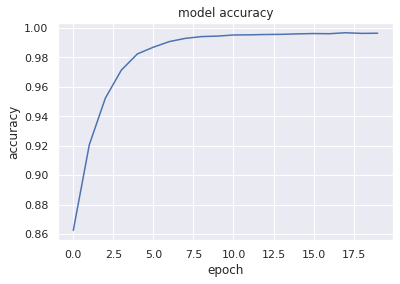

In [23]:
#Summarize history for accuracy (Binomial model)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [24]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_test))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_test = np.array([inverse_dic[y] for y in y_test])

In [25]:
## test
predicted_prob = model.predict(X_test_A)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

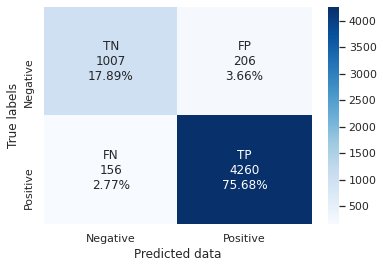

In [26]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

cf_matrix_bi = confusion_matrix(y_test, predicted)

#Lets look at it graphically:
group_names = ["TN", "FP", "FN", "TP"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_bi.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_bi.flatten() / np.sum(cf_matrix_bi)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
fig, ax = plt.subplots()
sns.heatmap(cf_matrix_bi, annot=labels, fmt="", cmap="Blues")
labels = ['Negative', 'Positive']
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_ylabel('True labels')
ax.set_xlabel('Predicted data')
plt.show()

In [27]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_A, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

88/88 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1213
           1       0.95      0.96      0.96      4416

    accuracy                           0.94      5629
   macro avg       0.91      0.90      0.90      5629
weighted avg       0.93      0.94      0.94      5629



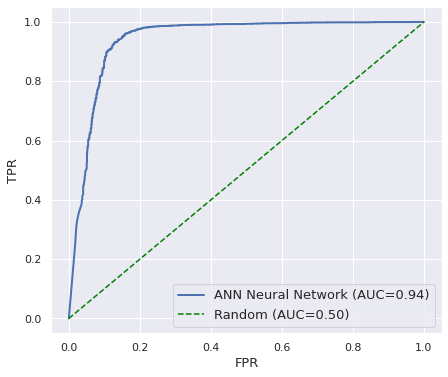

In [28]:
from sklearn.metrics import roc_curve, auc

#Roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])

#AUC
roc_auc = auc(fpr, tpr)

#Plot
plt.figure(figsize=[7, 6])
plt.plot(fpr, tpr, label="ANN Neural Network (AUC={:0.2f})".format(roc_auc), linewidth=2)

plt.plot([0, 1], [0, 1], color="green", linestyle="--", label="Random (AUC=0.50)")
plt.xlabel("FPR", fontsize=13)
plt.ylabel("TPR", fontsize=13)
plt.legend(loc="lower right", fontsize=13)
plt.show()